# Electron-Photon (Quantum)

This notebooks trains and evaluates quantum vision transformers for the electron-photon classification task.
You can find information about the dataset at https://arxiv.org/abs/1807.11916

In [1]:
import jax

from quantum_transformers.utils import plot_image
from quantum_transformers.datasets import get_electron_photon_dataloaders
from quantum_transformers.training import train_and_evaluate
from quantum_transformers.transformers import VisionTransformer
from quantum_transformers.quantum_layer import get_circuit

data_dir = '/global/cfs/cdirs/m4392/salcc/data'

2023-10-30 13:08:32.698164: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-30 13:08:32.698193: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-30 13:08:32.698216: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-30 13:08:36.241841: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Please first ``pip install -U cirq`` to enable related functionality in translation module


The models are trained using the following devices:

In [2]:
for d in jax.devices():
    print(d, d.device_kind)

gpu:0 NVIDIA A100-SXM4-80GB


Let's check how many samples the dataset has, the shape of the input data, and how one sample looks like.

Cardinalities (train, val, test): 439200 48800 10000
(32, 32, 2)


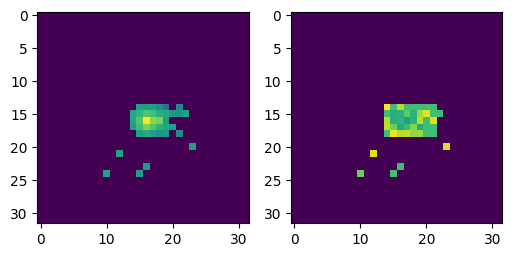

In [3]:
ep_train_dataloader, ep_val_dataloader, ep_test_dataloader = get_electron_photon_dataloaders(batch_size=512, data_dir=data_dir)
first_image = next(iter(ep_train_dataloader))[0][0]
print(first_image.shape)
plot_image(first_image, abs_log=True)

First, we train one good configuration with few parameters, which obtains a good AUC, although it is not as good as the classical baseline.

In [10]:
model = VisionTransformer(num_classes=2, patch_size=10, hidden_size=8, num_heads=2, num_transformer_blocks=4, mlp_hidden_size=4,
                          quantum_attn_circuit=get_circuit(), quantum_mlp_circuit=get_circuit())
test_loss, test_auc, test_fpr, test_tpr = train_and_evaluate(model, ep_train_dataloader, ep_val_dataloader, ep_test_dataloader, num_classes=2, num_epochs=50)

Number of parameters = 2290


Epoch  50/50: 100%|██████████| 857/857 [01:16<00:00, 11.16batch/s, Loss = 0.5735, AUC = 76.90%]                                                  


Total training time = 3906.78s, best validation AUC = 76.92% at epoch 49


Testing: 100%|██████████| 19/19 [00:01<00:00,  9.78batch/s, Loss = 0.5780, AUC = 76.55%]                                                         


Next, another hyperparameter configuration that was found by hyperparameter search is the following one, which obtains a test AUC which surpasses the best classical baseline! Moreover, the model is much smaller (less parameters). Curioulsy, the patch size is 32x32, which is the same size as the input images.

In [8]:
model = VisionTransformer(num_classes=2, patch_size=32, hidden_size=8, num_heads=4, num_transformer_blocks=8, mlp_hidden_size=4, pos_embedding='sincos',
                          quantum_attn_circuit=get_circuit(), quantum_mlp_circuit=get_circuit())
test_loss, test_auc, test_fpr, test_tpr = train_and_evaluate(model, ep_train_dataloader, ep_val_dataloader, ep_test_dataloader, num_classes=2, num_epochs=100, lrs_peak_value=0.004, lrs_warmup_steps=0, lrs_decay_steps=1000000)

Number of parameters = 17578


Epoch 100/100: 100%|██████████| 857/857 [00:35<00:00, 23.87batch/s, Loss = 0.5687, AUC = 77.89%]                                                 


Total training time = 3598.45s, best validation AUC = 77.93% at epoch 96


Testing: 100%|██████████| 19/19 [00:01<00:00, 12.19batch/s, Loss = 0.5653, AUC = 77.93%]                                                         
